# MDL DB roll decay evaluation
This notebook is building the roll damping database

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian, RolldecayDirectImproved
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_estimator_improved import DirectEstimatorImproved
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline

import signal_lab


c:\dev\rolldecay\venv\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [4]:
#lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.4, minimum_score=0.0)
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.99)
scaler = ScaleFactorTransformer(scale_factor=None)  # dummy value None for now
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(1))
offset_transformer = OffsetTransformer()
bounds = {
    'omega0':(0,np.inf) # Only positive natural frequency
    #'zeta':(0,np.inf),  # Only positive damping
    #'d':(0,np.inf),  # Only positive damping
}

## Linear method

In [5]:
direct_linear_estimator = DirectLinearEstimator(bounds=bounds)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
    ('linear_estimator', direct_linear_estimator)]
        
pipeline_direct_linear = Pipeline(steps) # define the pipeline object.

## Quadratic direct

In [6]:
direct_estimator = DirectEstimator(bounds=bounds)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
    ('direct_estimator', direct_estimator)]
        
pipeline_direct = Pipeline(steps) # define the pipeline object.

## Quandratic norwegian

In [7]:
norwegian_estimator = NorwegianEstimator(bounds=bounds)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
    ('norwegian_estimator', norwegian_estimator)]
        
pipeline_norwegian = Pipeline(steps) # define the pipeline object.

## Quadratic direct improved

In [8]:
direct_estimator_improved = DirectEstimatorImproved(bounds=bounds)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
    ('direct_estimator_imporved', direct_estimator_improved)]
        
pipeline_direct_improved = Pipeline(steps) # define the pipeline object.

In [9]:
def fit_predict(db_run, pipeline):
    
    ascii_file = db_run.load()
    df_raw = ascii_file.channels
    
    df = signal_lab.mdl_to_evaluation.do_transforms(df=df_raw)
        
    _pipline = copy.deepcopy(pipeline)
    
    scaler = _pipline['scaler']
    scaler.scale_factor = db_run.model.scale_factor
    
    df.rename(columns={'MA/Roll':'phi'}, inplace=True)
    
    # Fit:
    _pipline.fit(X=df)
    
    # Predict:
    estimator = _pipline[-1]
    s = {} 
    s.update(estimator.parameters)
    s['score'] = estimator.score(X=estimator.X)
    s['mean_damping'] = estimator.calculate_average_linear_damping()
    
    if not 'd' in s:
        s['d'] = 0
    
    return s,_pipline, df
    
    

In [10]:
roll_decay_tests = db.session.query(Run).filter(Run.test_type=='roll decay')

## Add roll decay

In [11]:
db_run = roll_decay_tests[0]
s, pipeline, df = fit_predict(db_run=db_run, pipeline=pipeline_direct_linear)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


In [12]:
s

{'d': 0,
 'mean_damping': 0.06954570532530072,
 'omega0': 0.376596253548057,
 'score': 0.9827702230445015,
 'zeta': 0.06954570532530072}

In [13]:
rolldecay_linear_db = RolldecayLinear(run_id=db_run.id,**s)
db.session.merge(rolldecay_linear_db)
db.session.commit()

In [14]:
def plot_pipeline(pipeline, df):
    df_ = df.copy()
    df_['n'] = n = np.arange(len(df_))
    pipeline = copy.deepcopy(pipeline)
    pipeline['scaler'].scale_factor = db_run.model.scale_factor
    
    fig,axes = plt.subplots(nrows=len(pipeline))
    fig.set_size_inches(15,7)
    ax=axes[0]
    df_.plot(x='n', y='phi', ax=ax, label='raw')
    ax.grid(True)
    ax.legend()
    
    for step,ax in zip(pipeline[0:-1],axes[1:]):
       
        step.fit(X=df_)
        df_ = step.transform(X=df_)
    
        df_.plot(x='n', y='phi', label=str(step), ax=ax)
        ax.set_xlim(n[0], n[-1])
        ax.grid(True)
        ax.legend()
    
    fig,ax = plt.subplots()
    fig.set_size_inches(15,5)
    estimator = pipeline[-1]
    estimator.fit(X=df_)
    df_pred = estimator.predict(X=df_)
    estimator.plot_fit(ax=ax)
        

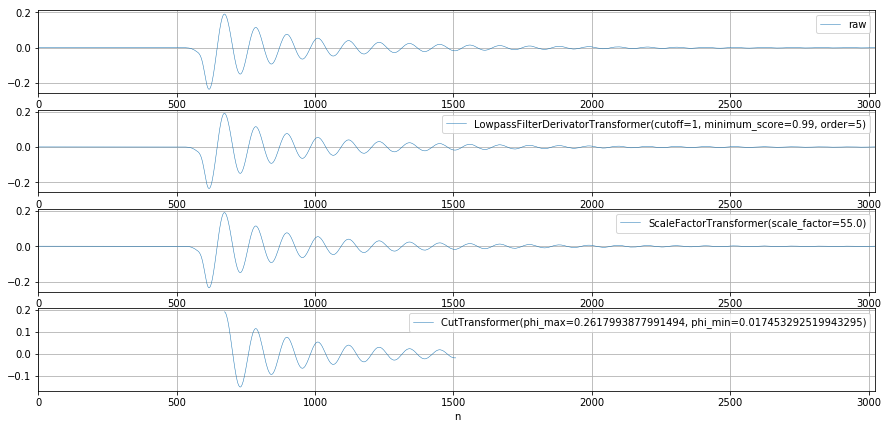

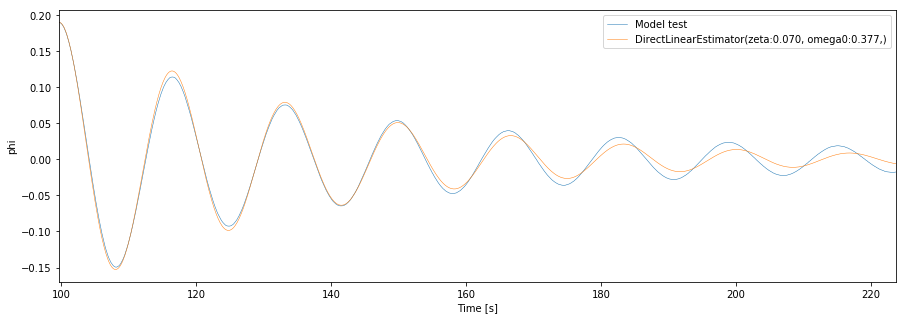

In [15]:
plot_pipeline(pipeline=pipeline_direct_linear,df=df)

In [16]:
roll_decay_tests = db.session.query(Run).filter(Run.test_type=='roll decay')

pipelines = [
    (pipeline_direct_linear,RolldecayLinear),
    (pipeline_direct,RolldecayDirect),
    (pipeline_norwegian,RolldecayNorwegian),
    (pipeline_direct_improved,RolldecayDirectImproved),
]

for db_run in roll_decay_tests:
    
    if db_run.ship_speed is None:
        db_run.ship_speed=0
    
    for item in pipelines:  
        p = item[0]
        DBClass = item[1]
        
        if db.session.query(DBClass).get(db_run.id):
            continue  # This has already been handled
        
        try:
            s, pipeline, df = fit_predict(db_run=db_run, pipeline=p)
        except:
            pass
        else:
        
            rolldecay_db = DBClass(run_id=db_run.id,**s)
            db.session.merge(rolldecay_db)
            db.session.commit()
        
        

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.p

In [17]:
df = db_run.load().channels

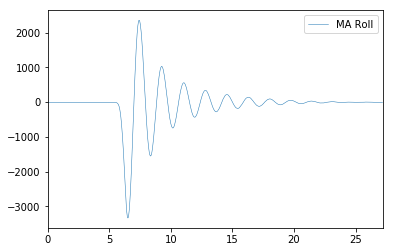

In [18]:
df.plot(y='MA Roll')